In [21]:
import math
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader, SubsetRandomSampler
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from datetime import datetime
from typing import Optional

## Experimental

In [23]:
class LeNet5AutoEncoder(nn.Module):

    def __init__(self, latent_size=5):
        
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )
        
        self.feature_compressor = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=latent_size*2)
        )
        
        self.feature_expander = nn.Sequential(
            nn.Linear(in_features=latent_size, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=120),
            nn.Tanh()
        )
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=120, out_channels=16, kernel_size=5, stride=1),
            nn.MaxUnpool2d(kernel_size=2),
            nn.Tanh(),
            nn.ConvTranspose2d(in_channels=16, out_channels=6, kernel_size=5, stride=1),
            nn.MaxUnpool2d(kernel_size=2),
            nn.Tanh(),
            nn.ConvTranspose2d(in_channels=6, out_channels=1, kernel_size=5, stride=1)
        )
    
    def encode(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1) # this is just the technical tensor reshaping. The *actual* flattening is the last 
                                # layer of the feature_extractor, which uses convolution to take the 5x5 feature maps into a single 1x1 value.
        logits = self.feature_compressor(x)
        return logits, probabilities
    
    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new_empty(std.size()).normal_()
            return eps.mul_(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        z = self.feature_expander(z)
        z = z.unsqueeze(2).unsqueeze(2) # Changing structure: flat->channels. Required for ConvTranspose
        return self.deconv(z)
    
    def forward(self, x):
        mu_and_logvar = self.encode(x).view(-1, 2, d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decode(z), mu, logvar
    
    


In [24]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    
NoiseTransform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    AddGaussianNoise(0., 1.)
])

## NN Utilities

In [25]:
def plot_losses_over_epochs(train_losses: list[float], valid_losses: list[float]):
    '''
    Graphically show the training and validation loss for each epoch.
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [26]:
def run_single_epoch(loader, criterion, model, optimizer, normalize_input_fn, normalize_labels_fn, positive_class = 1, train=True):
    '''
    Implementation a single epoch for the training/validation loop.
    '''        
    
    model.train() if train else model.eval() 
    
    running_loss = 0
    
    # Each iteration gets a batch from the train loader
    for X, Y_true in loader:
        X = normalize_input_fn(X) # Normalizing the input if necessary
        X = X.to(DEVICE)
        Y_true = Y_true.to(DEVICE)
        # Y_true = normalize_labels_fn(Y_true)
        # Y_true[Y_true == positive_class]  = 1 # We "normalize" the label of the positive class to be "1". Makes our lives easier (see comment below)
        
        optimizer.zero_grad() if train else None
        
        # Forward pass
        Y_logits, Y_prob = model(X)
        _, predicted_labels = torch.max(Y_prob, 1)  # The "1" is acutally misleading - it's the dimension to search the max in.
                                                        # This actually returns the indices of the highest prediction for each row, 
                                                        # but since the index is one-to-one with the predicted digit (i.e., 0 or 1), 
                                                        # we use the index of the max probability as the label that's being predicted
        batch_loss = criterion(Y_logits, Y_true) # we use the logits as the parameter since "CELoss already pefroms softmax internally.
        running_loss += batch_loss.item() * X.size(0) # X.size(0) is the size of the BATCH, not the image. 
                                                # The multiplication is required later for calculating the avg loss of the epoch step.
        
        # Backward pass, only required in training the model
        if train:
            batch_loss.backward()
            optimizer.step()
    
    avg_batch_loss_for_epoch = running_loss / len(loader.dataset)
    return model, optimizer, avg_batch_loss_for_epoch

In [27]:
def run_loop(train_loader, validation_loader, criterion, model, optimizer, positive_class=1, num_epochs=10, normalize_input_fn=lambda x: x, 
             normalize_labels_fn=lambda y: y, print_every=1):
    
    # Objects for storing metrics
    best_loss = 1e10
    train_losses = []
    validation_losses = []
    
    for epoch in range(num_epochs):
        print(f'Epoch: {epoch}\t')
        
        # Training the model
        _, _, train_loss = run_single_epoch(train_loader, criterion, model, optimizer, normalize_input_fn, normalize_labels_fn, positive_class)
        train_losses.append(train_loss)
        
        # No need for validation when working with a score model
        validation_losses.append(0)
        # # Validation
        # with torch.no_grad():
        #     _, _, validation_loss = run_single_epoch(validation_loader, criterion, model, None, normalize_input_fn, normalize_labels_fn, positive_class, False)
        #     validation_losses.append(validation_loss)
        
        if epoch % print_every == (print_every - 1):
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  # f'Vaildation loss: {validation_loss:.4f}\t')
                  f'Vaildation loss: 0\t')
    
    plot_losses_over_epochs(train_losses, validation_losses)
        
    return model, optimizer, (train_losses, validation_losses)

### LeNet5 Model

In [28]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes)
        )
        
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probabilities = F.softmax(logits, dim=1)
        return logits, probabilities


In [29]:
class SimpleDataSet(Dataset):
    def __init__(self, data, targets):
        super(SimpleDataSet, self).__init__()
        assert data.shape[0] == targets.shape[0] # assuming shape[0] = dataset size
        self.data = data
        self.targets = targets

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, index):
        return self.data[index], self.targets[index].item()

#### Training

In [36]:
def train_model(model, train_loader, test_loader):
    SEED = 42
    LEARNING_RATE = 1e-3
    N_CLASSES = 2

    torch.manual_seed(SEED)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    return run_loop(train_loader, test_loader, criterion, model, optimizer, normalize_input_fn=lambda x: x / 255.0, num_epochs=100)

In [31]:
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, datasetA, datasetB):
        super(ConcatDataset, self).__init__()
        self.datasetA = datasetA
        self.datasetB = datasetB

    def __getitem__(self, i):
        if i<len(self.datasetA):
            return self.datasetA[i]
        else:
            return self.datasetB[i-len(self.datasetA)]

    def __len__(self):
        return (len(self.datasetA) + len(self.datasetB))

In [32]:
import copy

def clone_and_new_computation_graph(t: torch.Tensor, requires_grad=True) -> torch.Tensor:
    '''
        Returns: 
            A Tensor with the same data (copied) as `t`, on a new computation graph
    '''
    t2 = torch.detach(t).clone()
    if requires_grad:
        t2.requires_grad_()
    return t2


def get_synthetic_h0_h1(training_set: SimpleDataSet, test_set: SimpleDataSet) -> tuple[SimpleDataSet, SimpleDataSet, SimpleDataSet, int]:
    '''
    Parameters:
        Training and Test datasets. Each of the following form:
            Dataset.data: 4-D tensor (batch size, channels, width, height). This is because nn.Conv2d expects input of this shape.
            Dataset.targets: 1-D tensor (target class)
    Returns:
        H0, H1, H1 with true target values (used for validation), K
    '''
    
    # k = math.floor(len(training_set) / 2) # TODO sample random k instead?
    k = len(training_set)- len(test_set) # TODO sample random k instead?
    # k = len(training_set) - 50
    original_training_data = training_set.data
    original_training_targets = training_set.targets

    # Create H0 set by *copying* the training set, and have it use a separate computation graph.
    h0_data = clone_and_new_computation_graph(original_training_data[:k])
    h0_targets = clone_and_new_computation_graph(original_training_targets[:k], requires_grad=False)
    h0_targets[:] = 0

    h0_set = SimpleDataSet(h0_data, h0_targets)
    
    # Create H1 and H1_true_targets sets by *copying* the data and have it use a separate computation graph
    h1_0_data = clone_and_new_computation_graph(original_training_data[k:])
    h1_0_targets = clone_and_new_computation_graph(original_training_targets[k:], requires_grad=False)
    h1_0_targets[:] = 1
        
    h1_0_data_for_true_targets = clone_and_new_computation_graph(original_training_data[k:])
    h1_0_true_targets = clone_and_new_computation_graph(original_training_targets[k:], requires_grad=False)
    
    original_test_data = test_set.data
    original_test_targets = test_set.targets
    h1_1_data = clone_and_new_computation_graph(original_test_data)
    h1_1_targets = clone_and_new_computation_graph(original_test_targets, requires_grad=False)
    h1_1_targets[:] = 1
    
    h1_1_data_for_true_targets = clone_and_new_computation_graph(original_test_data)
    h1_1_true_targets = clone_and_new_computation_graph(original_test_targets, requires_grad=False)
    
    h1_data = torch.cat((h1_0_data, h1_1_data), 0)
    h1_targets = torch.cat((h1_0_targets, h1_1_targets), 0)
    
    h1_set = SimpleDataSet(h1_data, h1_targets)
    
    h1_data_true = torch.cat((h1_0_data_for_true_targets, h1_1_data_for_true_targets), 0)
    h1_targets_true = torch.cat((h1_0_true_targets, h1_1_true_targets), 0)
    
    h1_set_with_true_targets = SimpleDataSet(h1_data_true, h1_targets_true)
    

    return h0_set, h1_set, h1_set_with_true_targets, k

In [33]:
BATCH_SIZE = 32

def run_discovery(training_set, test_set, score_model, auto_econder: Optional[torch.nn.Module]=None, alpha=0.1):
    print("--------- Discovery Started ---------")
    
    train_autoencoder(auto_econder, training_set) if auto_econder is not None else 0 
        
    # Split the train set to concat with the test set (creating the mixed set for discovery)
    h0_set, h1_set, h1_set_with_true_targets, k = get_synthetic_h0_h1(training_set, test_set)
    print(F"Training set size: {len(training_set)}, Test set size: {len(test_set)}")
    print(F"Selected K: {k}, h0 size: {len(h0_set)} , h1 size: {len(h1_set)}")
    h0h1_set = ConcatDataset(h0_set,h1_set)
    h0h1_loader = DataLoader(h0h1_set, batch_size=BATCH_SIZE, shuffle=True)
    # train_loader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
    # test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)
    
    # Training...
    train_model(score_model, h0h1_loader, None)
    
    # Got a trained model, let's get the scores
    with torch.no_grad():
        score_model.eval()
        _, probability_scores = score_model(h1_set.data.to(DEVICE)) # probability scores is a tensor of pairs (p(0), p(1)).
    probability_of_discovery = probability_scores[:,1].numpy() # We only care about the probability of a discovery (p(1))

    # Use BoNuS and Knockoff counting for stating discoveries while keeping FDR
    l = len(training_set)-k # This is the length of the "2nd part" of the null samples, which will be concatenated to the test sample
    m = len(test_set)
    
    scores_df = pd.DataFrame({'score': probability_of_discovery, 'is_test': np.concatenate((np.repeat(0, l),np.repeat(1,m))),'truth':h1_set_with_true_targets.targets.numpy()})
    scores_df.sort_values(by=['score'], inplace=True, ascending=True)
    
    fdp = 10 # a value which is definitely bigger than alpha
    
    for lower_bound in range(len(h1_set)):
        scores_window_df = scores_df[lower_bound:] # get the subset of the samples we want to test with.
        ktest = len(scores_window_df[scores_window_df['is_test']==1]) # This is the "moving" k, which changes as we move the lower score bound.
        v = len(scores_window_df[scores_window_df['is_test']==0]) # The count of false discoveries that we know of (i.e., training samples)
        fdp = ((v+1) / (l+1)) * (m / ktest)
        print(F"ktest: {ktest},\t"
              F"v: {v},\t"
              F"m: {m},\t"
              F"l: {l},\t"
              F"fdp: {fdp}")

        if fdp<=alpha:
            print(F"Got FDP of {fdp} <= alpha({alpha}) , for lower bound: {lower_bound}")
            break;
    
    total_elements = len(scores_window_df)
    total_discoveries = ktest
    false_discoveries = len(scores_window_df[(scores_window_df['is_test']==1) & (scores_window_df['truth']==0)])
    print(F"Total elements in window: {total_elements}")
    print(F"Total discoveries in window: {ktest}")
    print(F"False discoveries: {false_discoveries}")
    
    return dict(total_elements=total_elements, total_discoveries=total_discoveries, false_discoveries=false_discoveries)
    
    

In [34]:
def get_datasets_for_discovery(add_noise=False) -> tuple[SimpleDataSet, SimpleDataSet]:
    '''
    Returns:
        A Tuple of (Training dataset, Test dataset)
            Dataset.data: 4-D tensor (batch size, channels, width, height). This is because nn.Conv2d expects input of this shape.
            Dataset.targets: 1-D tensor (target class)
    '''
    
    image_padding_to_32 = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])
    
    if add_noise:
        raise NotImplementedError("adding noise was not yet implemented")
        
    # Get data of 4, then set the targets as "0" (as this is our "null" class).
    training_set_full = datasets.MNIST(root='./data', download=True, transform=image_padding_to_32, train=True)
    training_four_index = (training_set_full.targets == 4).nonzero().reshape(-1)
    train_four_loader = torch.utils.data.DataLoader(dataset=training_set_full, batch_size=len(training_four_index), shuffle=False, sampler=Data.SubsetRandomSampler(training_four_index))
    train_four_data, train_four_targets = next(iter(train_four_loader)) # We only need one iteration, as the loader has the size of the entire relevant sample
    
    assert len(train_four_targets[(train_four_targets!=4).nonzero().reshape(-1)])==0 # Avoid bugs in data loading. You're welcome hahaha
    train_four_targets[(train_four_targets==4).nonzero().reshape(-1)] = 0
    
    
    training_set = SimpleDataSet(train_four_data, train_four_targets)
    
    test_set_full = datasets.MNIST(root='./data', download=True, transform=image_padding_to_32, train=False)
    test_four_index = torch.logical_or(test_set_full.targets == 4, test_set_full.targets == 9).nonzero().reshape(-1)
    # test_four_index = (test_set_full.targets == 9).nonzero().reshape(-1)
    test_four_loader = torch.utils.data.DataLoader(dataset=test_set_full, batch_size=len(test_four_index), shuffle=False, sampler=Data.SubsetRandomSampler(test_four_index))
    test_four_data, test_four_targets = next(iter(test_four_loader))
    test_four_targets[(test_four_targets==4).nonzero().reshape(-1)] = 0
    test_four_targets[(test_four_targets==9).nonzero().reshape(-1)] = 1
    test_set = SimpleDataSet(test_four_data, test_four_targets)
    
    return training_set, test_set

--------- Discovery Started ---------
Training set size: 5842, Test set size: 1991
Selected K: 3851, h0 size: 3851 , h1 size: 3982
Epoch: 0	
12:42:37 --- Epoch: 0	Train loss: 0.6940	Vaildation loss: 0	
Epoch: 1	
12:42:45 --- Epoch: 1	Train loss: 0.6930	Vaildation loss: 0	
Epoch: 2	
12:42:52 --- Epoch: 2	Train loss: 0.6937	Vaildation loss: 0	
Epoch: 3	
12:42:59 --- Epoch: 3	Train loss: 0.6935	Vaildation loss: 0	
Epoch: 4	
12:43:07 --- Epoch: 4	Train loss: 0.6932	Vaildation loss: 0	
Epoch: 5	
12:43:14 --- Epoch: 5	Train loss: 0.6927	Vaildation loss: 0	
Epoch: 6	
12:43:21 --- Epoch: 6	Train loss: 0.6688	Vaildation loss: 0	
Epoch: 7	
12:43:28 --- Epoch: 7	Train loss: 0.6537	Vaildation loss: 0	
Epoch: 8	
12:43:36 --- Epoch: 8	Train loss: 0.6416	Vaildation loss: 0	
Epoch: 9	
12:43:43 --- Epoch: 9	Train loss: 0.6309	Vaildation loss: 0	
Epoch: 10	
12:53:08 --- Epoch: 10	Train loss: 0.6264	Vaildation loss: 0	
Epoch: 11	
12:53:16 --- Epoch: 11	Train loss: 0.6255	Vaildation loss: 0	
Epoch: 12	
12

/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_1845/1730830866.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_1845/1730830866.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


ktest: 1829,	v: 1801,	m: 1991,	l: 1991,	fdp: 0.9847432375757815
ktest: 1829,	v: 1800,	m: 1991,	l: 1991,	fdp: 0.9841967651908894
ktest: 1828,	v: 1800,	m: 1991,	l: 1991,	fdp: 0.9847351660471206
ktest: 1827,	v: 1800,	m: 1991,	l: 1991,	fdp: 0.9852741562857891
ktest: 1826,	v: 1800,	m: 1991,	l: 1991,	fdp: 0.9858137368752118
ktest: 1825,	v: 1800,	m: 1991,	l: 1991,	fdp: 0.9863539087858283
ktest: 1825,	v: 1799,	m: 1991,	l: 1991,	fdp: 0.9858062386532431
ktest: 1825,	v: 1798,	m: 1991,	l: 1991,	fdp: 0.985258568520658
ktest: 1824,	v: 1798,	m: 1991,	l: 1991,	fdp: 0.9857987322095398
ktest: 1823,	v: 1798,	m: 1991,	l: 1991,	fdp: 0.9863394885080641
ktest: 1822,	v: 1798,	m: 1991,	l: 1991,	fdp: 0.9868808383919873
ktest: 1822,	v: 1797,	m: 1991,	l: 1991,	fdp: 0.9863322664973836
ktest: 1821,	v: 1797,	m: 1991,	l: 1991,	fdp: 0.9868739096969978
ktest: 1821,	v: 1796,	m: 1991,	l: 1991,	fdp: 0.986325036554786
ktest: 1821,	v: 1795,	m: 1991,	l: 1991,	fdp: 0.985776163412574
ktest: 1821,	v: 1794,	m: 1991,	l: 1991,	fdp

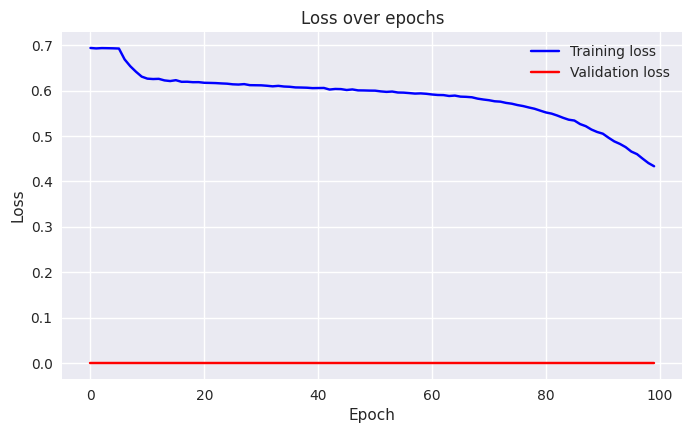

In [38]:
torch.manual_seed(42)
DISCOVERY_EPOCHS = 1
N_CLASSES = 2
# DEVICE = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
DEVICE = torch.device("cpu") # No point in using MPS for now :( See https://github.com/pytorch/pytorch/issues/77799

clean_training_set, clean_test_set = get_datasets_for_discovery()

model = nn.DataParallel(LeNet5(N_CLASSES)).to(DEVICE)

clean_discovery_results = []
for i in range(DISCOVERY_EPOCHS):
    clean_discovery_results.append(run_discovery(clean_training_set, clean_test_set, model))

# print(clean_discovery_results)
# noisy_discovery_results = []
# for i in range(DISCOVERY_EPOCHS):
#     noisy_discovery_results.append(run_discovery(clean_training_dataset, noisy_test_dataset, LeNet5(N_CLASSES)))

# ae_powered_noisy_discovery_results = []
# for i in range(DISCOVERY_EPOCHS):
#     ae_powered_noisy_discovery_results.append(run_discovery(clean_training_dataset, noisy_test_dataset, LeNet5(N_CLASSES), ae=LeNet5AutoEncoder(latent_size=20))
    
# compare_discovery_results([clean_discovery_results, noisy_discovery_results, ae_powered_noisy_discovery_results])

In [4]:
torch.save(model, "/Users/danielputerman/personal/thesis/experiment2-model.pt")

NameError: name 'model' is not defined